In [1]:
!nvidia-smi

Mon Dec 25 04:03:49 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install -U "huggingface_hub[cli]"

  Using cached huggingface_hub-0.20.1-py3-none-any.whl.metadata (12 kB)
  Using cached InquirerPy-0.3.4-py3-none-any.whl (67 kB)
  Using cached pfzy-0.3.4-py3-none-any.whl (8.5 kB)
Using cached huggingface_hub-0.20.1-py3-none-any.whl (330 kB)


In [4]:
!huggingface-cli login --token HUGGINGFACE_TOKEN

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/jovyan/.cache/huggingface/token
Login successful


In [5]:
!pip install transformers accelerate datasets scipy ipywidgets peft bitsandbytes

  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
  Using cached peft-0.7.1-py3-none-any.whl.metadata (25 kB)
  Using cached bitsandbytes-0.41.3.post2-py3-none-any.whl.metadata (9.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 796.6 kB/s eta 0:00:00 0:00:01
  Using cached tokenizers-0.15.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached safetensors-0.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached xxhash-3.4.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.15-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached aiohttp-3.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
  Using cached multidict-6.0.4-cp311-cp311-manylinux_2_17_x86_64.man

In [1]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [2]:
from datasets import load_dataset

train_dataset = load_dataset('gem/viggo', split='train')
eval_dataset = load_dataset('gem/viggo', split='validation')
test_dataset = load_dataset('gem/viggo', split='test')

Extracting data files:   0%|          | 0/8 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating challenge_train_1_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_2_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_5_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_10_percent split: 0 examples [00:00, ? examples/s]

Generating challenge_train_20_percent split: 0 examples [00:00, ? examples/s]

In [3]:
print(train_dataset)
print(eval_dataset)
print(test_dataset)

Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 5103
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 714
})
Dataset({
    features: ['gem_id', 'meaning_representation', 'target', 'references'],
    num_rows: 1083
})


In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=512,
    padding_side="left",
    add_eos_token=True)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [6]:
def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [7]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
{data_point["target"]}

### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/5103 [00:00<?, ? examples/s]

Map:   0%|          | 0/714 [00:00<?, ? examples/s]

In [9]:
print(tokenized_train_dataset[4]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 12628, 264, 2718, 12271, 5122, 272, 14164, 5746, 9283, 302, 272, 2787, 12271, 390, 264, 2692, 908, 395, 9623, 304, 6836, 30

In [10]:
print(len(tokenized_train_dataset[4]['input_ids']))

512


In [11]:
print("Target Sentence: " + test_dataset[1]['target'])
print("Meaning Representation: " + test_dataset[1]['meaning_representation'] + "\n")

Target Sentence: Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?
Meaning Representation: verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no], platforms[PlayStation])



In [12]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

In [13]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2023-12-22 06:21:50.479494: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-22 06:21:50.479549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-22 06:21:50.481213: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-22 06:21:50.488933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate c

Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:

```
[
  {
    "function": "request",
    "attributes": [
      {
        "attribute": "name",
        "value": "Little Big Adven

In [1]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.0.0
accelerate                        0.25.0
aiofiles                          22.1.0
aiohttp                           3.9.1
aiosignal                         1.3.1
aiosqlite                         0.19.0
alembic                           1.13.0
altair                            5.2.0
anyio                             4.2.0
archspec                          0.2.2
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         2.4.1
astunparse                        1.6.3
async-generator                   1.10
async-lru                         2.0.4
attrs                             23.1.0
Babel                             2.14.0
beautifulsoup4                    4.12.2
bitsandbytes                      0.41.3.post2
bleach                            6.1.0
blinker         

In [6]:
!pip install ipywidgets matplotlib

In [11]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='notes.json', split='train')
eval_dataset = load_dataset('json', data_files='notes_validation.json', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text

In [12]:
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text

In [13]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

2


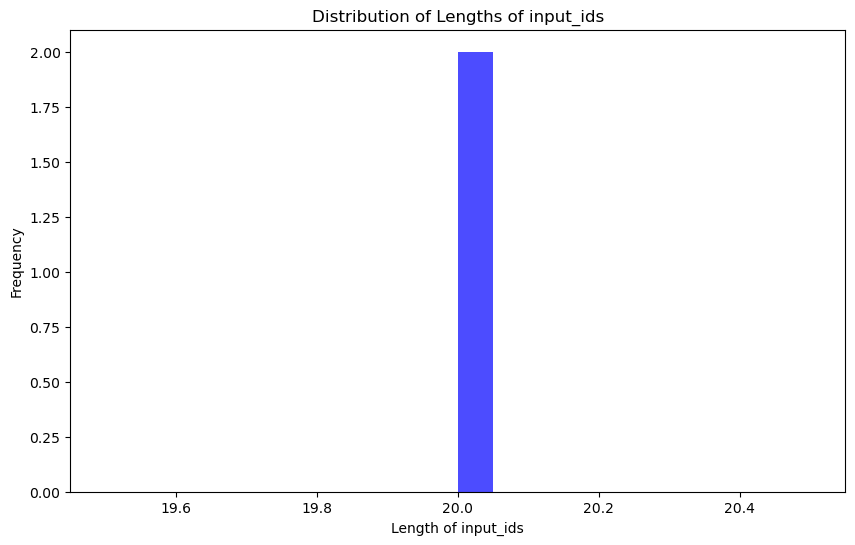

In [16]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)